# Working with output from general circulation models using xesmf and xgcm

In this lecture, we will discuss some fundamental aspects and techniques to work with the output of general circulation models.

## What is a general circulation model?

A general circulation model (GCM) is a computer model that simulates the circulation of a fluid (e.g., the ocean or atmosphere). The model is based on a set of partial differential equations, which describe the motion of a fluid in 3D space, and integrates these forward in time.  Most fundamentally, these models use a discrete representation of the [Navier-Stokes Equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) but can include more equations to represent e.g., the thermodynamics, chemistry or biology of the coupled earth system.

### The globe divided into boxes
Since there is no analytical solution to the full Navier-Stokes equation, modern GCMs solve them using numerical methods. They use a discretized version of the equations, which approximates them within a finite volume, or grid-cell. Each GCM splits the ocean or atmosphere into many cells, both in the horizontal and vertical.

![gcm-schematic](https://www.ipcc-data.org/img/3d_gcm_structure.jpg)
> Source: www.ipcc-data.org

It is numerically favorable to shift (or 'stagger') the grid points where the model calculates the velocity with regard to the grid point where tracer values (temperature, salinity, or others) are calculated. There are several different ways to shift these points, commonly referred to as [Arakawa grids](https://en.wikipedia.org/wiki/Arakawa_grids). Most modern ocean models use a C-Grid. Thus, this lecture will focus on this particular grid configuration.
In the C-grid, the zonal velocity $u$ is located on the right side (or east face) of the tracer location and the meridional velocity $v$ is located on the upper side (or north face). Similarly, the vertical velocity $w$ is shifted with depth, but horizontally (when looking at it from straight above), it is on the tracer location.

![c-grid](https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg)
> Source: xgcm.readthedocs.io

### Grid resolution
Discretizing the equations has consequences: 

- In order to get a realistic representation of the global circulation, the size of grid cells needs to be chosen so that all relevant processes are resolved.  In reality, this usually requires too much computing power for global models and so processes that are too small to be explicitly resolved, like [mesoscale eddies](https://www.gfdl.noaa.gov/ocean-mesoscale-eddies/) or [vertical mixing](https://www.gfdl.noaa.gov/ocean-mixing/), need to be carefully parameterized since they influence the large scale circulation. The following video illustrates the representation of mesoscale eddies in global models of different grid resolution. It shows the surface nutrient fields of three coupled climate models (produced by NOAA/GFDL) around the Antarctic Peninsula with increasing ocean resolution from left to right.

In [2]:
# Video to show difference in resolution
# from IPython.display import HTML
# HTML('<iframe src="https://player.vimeo.com/video/259423826" width="640" height="360" frameborder="0" allow="autoplay; fullscreen" allowfullscreen></iframe>')
from IPython.display import IFrame#, VimeoVideo, HTML
IFrame("https://player.vimeo.com/video/259423826", width="640", height="360")
# HTML('<div style="text-align: center"><iframe width="640", height="360" src="https://player.vimeo.com/video/259423826" frameborder="4"></iframe></div>')
# VimeoVideo()

**Nominal model resolution from left to right: 1 degree (CM2.1deg), 0.25 degree (CM2.5) and 0.1 degree (CM2.6). The left ocean model employs a parametrization for both the advective and diffusive effects of mesoscale eddies, while the middle and right model do not.**

> We will learn how to `regrid` high-resolution model fields in order to compare them to observations in the first part of this lecture.

- While regridding is necessary to compare model output to other datasets, some calculations should be performed on the native model grid for maximum accuracy. This is usually the case when you want to derive additional quantities, like the gradient or divergence of a field. Most GCMs use a [curvilinear grid](https://en.wikipedia.org/wiki/Curvilinear_coordinates) to avoid infinitely small grid cells at the North Pole. Some examples of curvilinear grids are a tripolar grid (the Arctic region is defined by two poles, placed over landmasses, see Figure below) or a cubed-sphere grid (several connected patches of curvilinear grids, see Figure below).
In most ocean models, due to these 'warped' coordinate systems, the boxes described are not perfectly rectangular[cuboids](https://en.wikipedia.org/wiki/Cuboid). To accurately represent the volume of the cell, we require so-called grid metrics - the distances, cell areas, and volume to calculate operators like e.g., divergence.

> We will learn how to use [xgcm](https://xgcm.readthedocs.io/en/latest/) in order to deal with computations on the raw model grid. 

## Part 1: Model validation: Comparing a state estimate to observations

We start by importing xarray, numpy and matplotlib as usual

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The model we will be using in this lecture is the [Southen Ocean State Estimate (SOSE)](http://sose.ucsd.edu), which is available in the pangeo cloud as an [intake catalogue](https://pangeo-data.github.io/pangeo-datastore/master/ocean.html). We will just follow the [instructions](https://pangeo-data.github.io/pangeo-datastore/master/ocean.html#collapse1-sose) how to load the data into our notebook and inspect the dataset.

In [3]:
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_model = cat["SOSE"].to_dask()
ds_model

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

This dataset has a lot of output variables. For this lecture we are going to focus on sea surface temperature. In the model this is represented by the surfac layer in the vertical (dimension `Z`) of the temperature dataarray `THETA`. 

Lets create a new `sst_model` dataarray and plot the first time step.

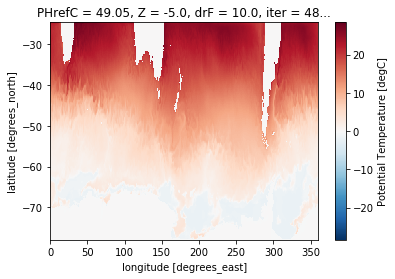

In [4]:
sst_model = ds_model.THETA.isel(Z=0)
sst_model.isel(time=0).plot()

As the name suggests, this model output is not global, but instead focusses on the Southern Ocean.
A common analysis step is model validation - comparing model output to an observation of the same variable. We will use the previously used sea surface temperature dataset. 

We load the dataset as before, but limit the latitude dimension to exclude values in the tropics and the northern hemisphere.
> Note that the `lon` dimension in the dataset is given in descending order, e.g. the first value is the northernmost. You can change the order by applying `sortby('lat')`, which will reshuffle the full dataset so that `lat` values are monotonically increasing.

In [5]:
# xr.set_options(display_style='html') # !!! need to update xarray for this?
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_obs = xr.open_dataset(url).chunk({'time': 12}).sortby('lat')
# restrict the obs to the southern ocean
ds_obs = ds_obs.sel(lat=slice(-90, -25))
ds_obs

<xarray.Dataset>
Dimensions:    (lat: 32, lon: 180, nbnds: 2, time: 1990)
Coordinates:
  * lat        (lat) float64 -88.0 -86.0 -84.0 -82.0 ... -32.0 -30.0 -28.0 -26.0
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-10-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 dask.array<shape=(1990, 2), chunksize=(12, 2)>
    sst        (time, lat, lon) float32 dask.array<shape=(1990, 32, 180), chunksize=(12, 32, 180)>
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs wer

Lets now define a new dataarray so that we have a consistent naming between the model output and observations. As before we also plot the first time step of the data.

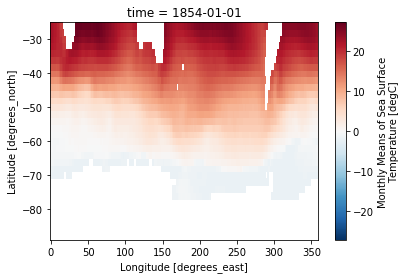

In [6]:
sst_obs = ds_obs.sst
sst_obs.isel(time=0).plot()

### Considerations for model validation
Now that we have both datasets loaded, how do we approach the model validation?


It is always crucial to put some thought into which time periods of a model and observations are actually comparable. In this case both should be directly comparable since SOSE is a state estimate, which incorporates observations to estimate the state of the ocean at the time observations were taken (and in between). If however the model data would be from a fully coupled climate model, we would have to take e.g. long averages due to the fact that internal variability - like for instance ENSO - can not be expected to happen in the same year as observations. But since we chose a state estimate, we can actually compare the data in a single year or even month (this will save us some computing time, but if you are interested, go ahead and choose a longer averaging period below and compare the results).

Now select a time period that overlaps between model and observations, e.g. the year 2009 and average over the year.

In [7]:
sst_model = sst_model.sel(time='2009').mean('time').load()
sst_obs = sst_obs.sel(time='2009').mean('time').load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


For later we will also rename the model dimensions `XC` and `YC` into `lon` and `lat`, so that both model and observations are named consistently.

In [8]:
sst_model = sst_model.rename({'XC':'lon', 'YC':'lat'})

We can now plot both fields next to each other. By specifying `vmax=30` in the plot command, we ensure that both plots have the exact same colorbar.

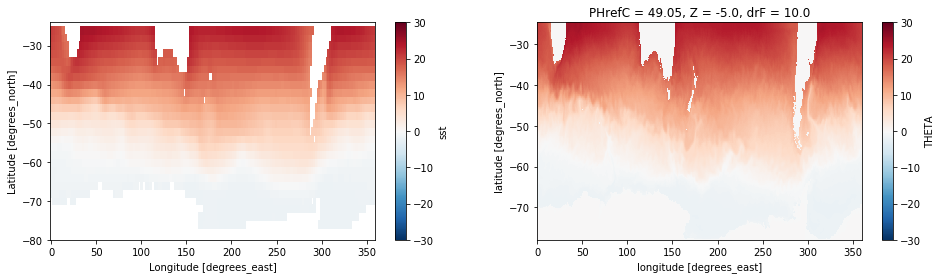

In [9]:
plt.figure(figsize=[16,4])
plt.subplot(1,2,1) # !!! is this taught before?
sst_obs.plot(vmax=30) # make sure to have the same colorlimit
plt.ylim(-80, -24)

plt.subplot(1,2,2)
sst_model.plot(vmax=30)

This looks nice and the large scale structure (colder waters near Antarctica) agree. But since temperature differs over such a wide range, it is hard to quantify the differences with the naked eye. Naturally we would want to plot the difference between both datasets. 

### Regridding via interpolation

There is however a major problem: Both datasets are on a different grid - the model has a much higher resolution (~ 1/5 deg) than the observations (~ 2 degree). In the model we can see signs of mesoscale eddies, even in the yearly average.

To compare the dataset directly they have to be on the same grid, e.g. each point of the array has to correspond to the same position.

*We have 3 options to achieve this*:

1. Regrid the lower resolution dataset (observations) onto the higher resolution dataset (model).
2. Regrid the higher resolution dataset (model) onto the lower resolution dataset (observations).
3. Define a completely new grid and regrid both datasets onto that.

Both 1. and 2. have unique advantages and disadvantages, whereas 3. can share some or all of these, depending on whether the new grid is defined on a higher, lower or intermediate resolution compared to the two datasets.

Lets try both approaches and see how they compare. For this step we will use [xesmf](https://xesmf.readthedocs.io/en/latest/) a very powerful geospatial regridding tool.

In [10]:
import xesmf as xe

To regrid a dataarray with xesmf you need to execute the following steps:

1. Create a target grid dataset (this can also be an existing dataset)
    
    > Note: Rename the dataset appropriately. xesmf expects longitude and latitude to be labelled as `lon` and `lat` (this is the reason we renamed the model dataset previously).
2. Create a `regridder` object (using the target grid and the source dataset - e.g. the dataset that should be regridded)
    
    > Note: You might have to clean existing files that the regridder might have written out using `regridder.clean_weight_file()` (this is only needed if the regridder has been previously applied, but it does not hurt to apply it just in case)
3. Apply the `regridder` to a dataset, e.g. `regridder(ds)`

We will start by regridding the low resolution observations onto the high resolution model grid, by using linear interpolation in two dimensions (`bilinear`) and specifying that our domain is periodic.

In [11]:
regridder = xe.Regridder(sst_obs, sst_model, 'bilinear', periodic=True) #since this is global we need to pass periodic
regridder.clean_weight_file()
regridder

Create weight file: bilinear_32x180_320x2160_peri.nc
Remove file bilinear_32x180_320x2160_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_32x180_320x2160_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (32, 180) 
Output grid shape:          (320, 2160) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

We can now apply the regridder to the observed sea surface temperature.

In [12]:
sst_obs_regridded = regridder(sst_obs)
sst_obs_regridded

<xarray.DataArray 'sst' (lat: 320, lon: 2160)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lon      (lon) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * lat      (lat) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
Attributes:
    regrid_method:  bilinear

You see that the size of the dimensions has increased. It is now the same as the model data. Lets see how the regridded data compares.

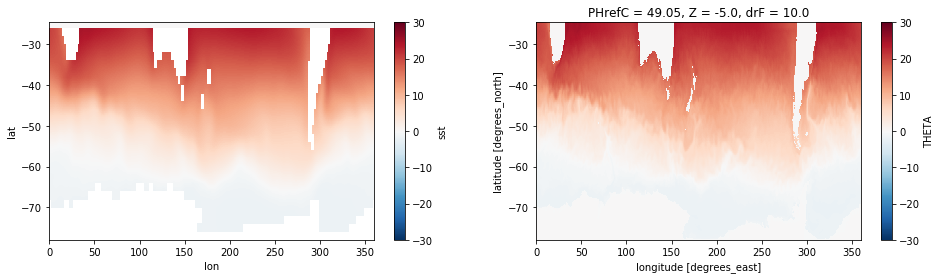

In [13]:
plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
sst_obs_regridded.plot(vmax=30) # make sure to have the same colorlimit
# plt.ylim(-80, -24)

plt.subplot(1,2,2)
sst_model.plot(vmax=30)

The observations now have more datapoints and look a lot smoother, but since the values are just linearly interpolated, there is no new information on smaller scales. 

Now lets compare both estimates by computing the difference.

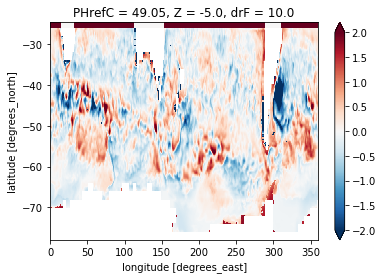

In [14]:
diff = sst_model - sst_obs_regridded 
diff.plot(vmax=2)

We can see that the model sea surface temperature is quite a bit different (up to 2 deg C in some places). But the comparison is hindered by a lot of smaller scale structure that stems from eddies in the model data, which are not resolved in the observations. 

This is the major disadvantage of Method 1. from above: The comparison becomes 'unfair' because we are usually only interested on larger scale differences. Even if the observations would have a higher resolution, from our physical understanding we would not expect that turbulent features like ocean eddies would happen at the exact same space and time in the model as the observations.

So how do we solve this issue? Lets look at method 2. to compare the model and observations on a lower resolution.
We first try the exact same procedure as befor (linear interpolation), but switch the source and target datasets.

In [15]:
regridder = xe.Regridder(sst_model,sst_obs, 'bilinear', periodic=True) #since this is global we need to pass periodic
regridder.clean_weight_file()
sst_model_regridded = regridder(sst_model)
sst_model_regridded

Create weight file: bilinear_320x2160_32x180_peri.nc
Remove file bilinear_320x2160_32x180_peri.nc


<xarray.DataArray 'THETA' (lat: 32, lon: 180)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [20.185935, 19.964374, 19.690668, ..., 20.646542, 20.335984, 20.317114],
       [20.801154, 20.477957, 20.144566, ..., 21.67011 , 21.22205 , 21.067159],
       [20.903206, 20.605169, 20.364102, ..., 21.828444, 21.537927, 21.231561]])
Coordinates:
    PHrefC   float32 49.05
    Z        float32 -5.0
    drF      float32 10.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 ... -32.0 -30.0 -28.0 -26.0
Attributes:
    regrid_method:  bilinear

Lets compare the original observations against the regridded model data as before

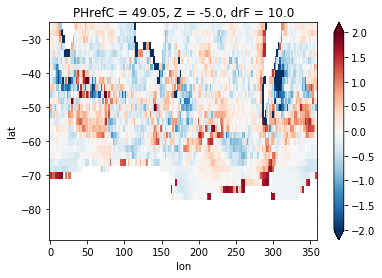

In [16]:
diff = sst_model_regridded - sst_obs
diff.plot(vmax=2)

That was easy enough, but there is a problem with this approach. Using linear interpolation works very well when we 'upsample' (going from lower to higher resolution), since most of the interpolated points are between the wider spaced original data. If we 'downsample' (going from higher resolution to lower resolution), this method will only use the two nearest points to infer a new value. This means most of the high resolution source data is not taken into consideration, and small noisy features can have a disproportionate influence on the regridded data. It also implies that properties like tracer concentrations over the full domain are not necessarily conserved.

We can plot the original and the downsampled modeldata along a constant latitude to illustrate the problem 

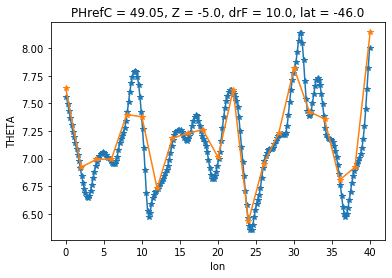

In [34]:
sample_lat = -46
sst_model.sel(lat=sample_lat, method='nearest').sel(lon=slice(0,40)).plot(marker='*')
sst_model_regridded.sel(lat=sample_lat, method='nearest').sel(lon=slice(0,40)).plot(marker='*')

As you can see the upsampled datapoints depend highly on the position of the target grid. What we should rather do in this case is average values around the wider target grid. This can be achieved by using a different method in xesmf.

### Regridding using conservative interpolation

The `conservative` option will take an average over several grid cells to reduce the resolution of the model. This ensures that no information is discarded and that for instance adjacent positive and negative anomalies are not increasing the noise in the regridded data.

This method is always preferable, when moving to lower resolutions, especially when the data is not very smooth. Unfortunately this also requires some more input parameter, namely the bounding coordinates of each gridpoint (in addition to the center or tracer coordinate; see schematic in the introduction). xesmf expects those coordinates to be named `lon_b` and `lat_b`.

When we look carefully at the model data, these bounding coordinates are already given (as the coodinates for the $u$ and $v$ velocities on a staggered grid - `XC` and `YC` respectively), but xesmf requires a bounding value at each side (This model does only provides the same amount of coordinate values for both tracer and velocity points).

We have two options: a) Remove one of the tracer points and leave the velocity points as is, or b) add an additional coordinate value. 

Since the model has a significantly higher resolution, we will chose the simpler way a) and just remove one tracer point, omitting one out of 10 points for the new coarse grid (which is acceptable in this case).

In [18]:
modified_grid_model = ds_model.isel(XC=slice(0,-1),
                                    YC=slice(0,-1)).rename({'XC':'lon',
                                                            'XG':'lon_b',
                                                            'YC':'lat',
                                                            'YG':'lat_b'})

modified_grid_model

<xarray.Dataset>
Dimensions:   (Z: 42, Zl: 42, Zp1: 43, Zu: 42, lat: 319, lat_b: 320, lon: 2159, lon_b: 2160, time: 438)
Coordinates:
    Depth     (lat, lon) float32 dask.array<shape=(319, 2159), chunksize=(319, 2159)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * lon       (lon) float32 0.083333336 0.25 0.4166667 ... 359.58334 359.75
  * lon_b     (lon_b) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * lat       (lat) float32 -77.87497 -77.7083 ... -25.041632 -24.874966
  * lat_b     (lat_b) float32 -77.9583 -77.79163 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.a

For the observations we choose method b. 

Since the data are given on a regular 2 by 2 degree grid, we construct the bounding coordinates by subtracting 1 deg of the center point and adding another point at the end. 

In [19]:
lon_boundary = np.hstack([ds_obs.coords['lon'].data - 1.0, ds_obs.coords['lon'][-1].data + 1])
lat_boundary = np.hstack([ds_obs.coords['lat'].data - 1.0, ds_obs.coords['lat'][-1].data + 1])

modified_grid_obs = ds_obs
modified_grid_obs.coords['lon_b'] = xr.DataArray(lon_boundary, dims=['lon_b'])
modified_grid_obs.coords['lat_b'] = xr.DataArray(lat_boundary, dims=['lat_b'])
modified_grid_obs

<xarray.Dataset>
Dimensions:    (lat: 32, lat_b: 33, lon: 180, lon_b: 181, nbnds: 2, time: 1990)
Coordinates:
  * lat        (lat) float64 -88.0 -86.0 -84.0 -82.0 ... -32.0 -30.0 -28.0 -26.0
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-10-01
  * lon_b      (lon_b) float64 -1.0 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * lat_b      (lat_b) float64 -89.0 -87.0 -85.0 -83.0 ... -29.0 -27.0 -25.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 dask.array<shape=(1990, 2), chunksize=(12, 2)>
    sst        (time, lat, lon) float32 dask.array<shape=(1990, 32, 180), chunksize=(12, 32, 180)>
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywo

Now we can create a conservative `regridder` by passing the modified grids and the method `conservative`.

In [20]:
regridder = xe.Regridder(modified_grid_model, modified_grid_obs, 'conservative') #since this is global we need to pass periodic
regridder.clean_weight_file()

Create weight file: conservative_319x2159_32x180.nc
Remove file conservative_319x2159_32x180.nc


We then apply this new regridder to the model again. Note that we have to cut one data point of again, as done above for the full dataset. 

In [21]:
sst_model_regridded_cons = regridder(sst_model.isel(lon=slice(0,-1), lat=slice(0,-1)))
sst_model_regridded_cons

/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


<xarray.DataArray 'THETA' (lat: 32, lon: 180)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [18.509935, 19.955008, 19.740049, ..., 20.661682, 20.400264, 20.323238],
       [19.04155 , 20.459897, 20.165475, ..., 21.616568, 21.226791, 21.009231],
       [19.162298, 20.607543, 20.363888, ..., 21.796622, 21.500974, 21.201145]])
Coordinates:
    PHrefC   float32 49.05
    Z        float32 -5.0
    drF      float32 10.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 ... -32.0 -30.0 -28.0 -26.0
Attributes:
    regrid_method:  conservative

Now we can compare the difference between the datasets using both the interpolation and conservative method.

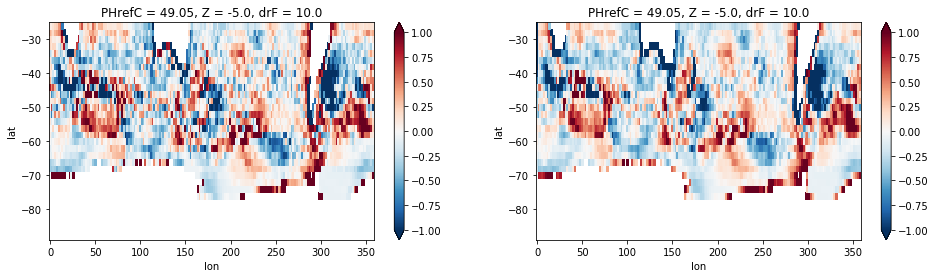

In [22]:
plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
diff = sst_model_regridded - sst_obs
diff.plot(vmax=1)

plt.subplot(1,2,2)
diff = sst_model_regridded_cons - sst_obs
diff.plot(vmax=1)

As expected the downsampling (regridding to lower resolution) via interpolation shows more noise. But even in the conservative regridding case there are still many alternating positive and negative anomalies, indicative of the fact that the observations so not resolve features down to the scale of the grid. This is a common issue with observational datasets, which have to use smoothing techniques to aquire a gridded dataset from point measurements.

So lastly we will conservatively regrid both datasets to an even coarser resolution (Method 3.) to alleviate some of this problematic.

To do this we define a coarse global grid using `xesmf.util.grid_global` and cut it appropriately (remember to leave the bounding coordinates `lon_b` and `lat_b` one element longer).

In [23]:
coarse_grid = xe.util.grid_global(5,5).isel(y=slice(0,16), y_b=slice(0,17))
coarse_grid

<xarray.Dataset>
Dimensions:  (x: 72, x_b: 73, y: 16, y_b: 17)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 -87.5 -87.5 -87.5 -87.5 ... -12.5 -12.5 -12.5 -12.5
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 ... 160 165 170 175 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 ... -10 -10 -10 -10 -10
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Now we define two new regridders and create dataarrays like before.
First with the modified model grid and the new coarse grid:

In [24]:
regridder = xe.Regridder(modified_grid_model, coarse_grid, 'conservative') #since this is global we need to pass periodic
regridder.clean_weight_file()
sst_coarse_model = regridder(sst_model.isel(lon=slice(0,-1), lat=slice(0,-1)))

Create weight file: conservative_319x2159_16x72.nc
Remove file conservative_319x2159_16x72.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Then with the modified model grid and the new coarse grid:

In [25]:
regridder = xe.Regridder(modified_grid_obs, coarse_grid, 'conservative') #since this is global we need to pass periodic
regridder.clean_weight_file()
sst_coarse_obs = regridder(sst_obs)

Create weight file: conservative_32x180_16x72.nc
Remove file conservative_32x180_16x72.nc


As a final step we visualize all four comparisons next to each other usign a Stereographic projection of the South Pole:

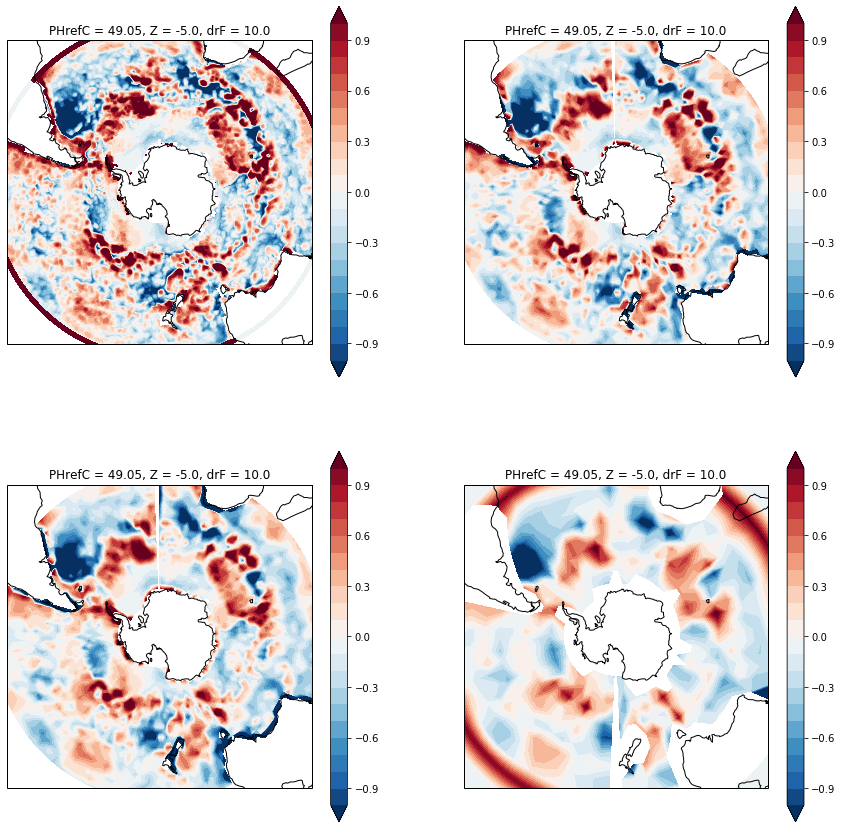

In [26]:
import cartopy.crs as ccrs

fig, axarr = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection':ccrs.SouthPolarStereo()}, figsize=[15,15])

for ds, ax in zip([sst_model - sst_obs_regridded, sst_model_regridded - sst_obs, sst_model_regridded_cons - sst_obs, sst_coarse_model - sst_coarse_obs],
                  axarr.flat):
    ds.plot.contourf(ax=ax, levels=21, vmax=1, x='lon', y='lat', transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax.coastlines()

Ultimately which method you use will depend on the particular use case. Before regridding, carefully inspect your datasets and think of what you want to achieve:
    
  * Are both datasets of a similar resolution and relatively smooth? Then using linear interpolation should be acceptable and is by far the easiest way to compare the datasets.
  * Is the goal of the comparison to evaluate differences on larger scales than the grid scale? Then create a coarser grid and interpolate conservatively to gain a larger scale perspective without getting distracted by smaller scale features.

## Part 2: Calculating properties in the native model grid using xgcm

For maximum accuracy it is always preferrable to calculate properties in the closest way possible to the model code, which at the least means executing calculations on the native grid. For comparison you can then regrid properties afterwards. To demonstrate how to do this we now calculate the meridional sea surface temperature gradient for the SOSE output.

For these sort of calculations we use [xgcm](https://xgcm.readthedocs.io/en/latest/index.html), which helps us to deal with the staggered grids that models use:

In [27]:
from xgcm import Grid

in order to work with xgcm we have to create a `Grid` object which 'understands' which coordinates of a dataset are representing the various staggered grid positions.

But first we need to check quickly how the model grid is designed. 

In [28]:
print(ds_model.XC[0] < ds_model.XG[0])
print(ds_model.YC[0] < ds_model.YG[0])

<xarray.DataArray ()>
array(False)
Coordinates:
    XC       float32 0.083333336
    XG       float32 5.551115e-17
<xarray.DataArray ()>
array(False)
Coordinates:
    YC       float32 -77.87497
    YG       float32 -77.9583


We can see that for the first datapoint of the dataset, the 'grid coordinates' (`XG` and `YG`) have smaller values than the 'tracer coordinates' (`XC` and `YC`). This means that for both `axes` (each axis decribes a logical direction and both tracer and grid coordinates), the tracer coordinate is at the center and the grid coordinate is on the left (this can be on the right for some model setups; thus, carefull checking beforehand is always recommended).

With this information, we can now construct the `Grid` object and configure it properly (this step is only required once for a single grid).

In [29]:
grid = Grid(ds_model,
            coords={'X': {'center': 'XC', 'left': 'XG'},
                    'Y': {'center': 'YC', 'left': 'YG'}})

The `grid` object can now be used to apply various operations on the data variables of the dataset. Most GCMs calculate all properties by using simple differences and interpolation between neighboring cells.

We first select the surface layer of temperature and average over year 2009.

In [30]:
sst = ds_model.THETA.isel(Z=0).sel(time='2009').mean('time')

In order to compute the meridional gradient of sea surface temperature, we have to simply compute the finite difference along axis `Y`.

In [31]:
deltay_sst = grid.diff(sst, 'Y')
deltay_sst

<xarray.DataArray 'sub-9563c8ac51aadebd24c532c2db11db98' (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(1, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167

If you look carefully, you see that the `Y` dimension has been shifted, from `YC` to `YG`. The gradient is defined on the cell face or $v$ velocity point. This is however just a difference between cells. To derive the gradient in the y direction in physical units `degC/m`, we need to divide the array by the distance along the `Y` axes between adjacent tracer points `dyC` , which itself is located at the $v$ velocity point.

In [32]:
dsst_dy = deltay_sst / ds_model.dyC
dsst_dy

<xarray.DataArray (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(1, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    dxG      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    dyC      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    rAs      (YG, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>

Now lets select the surface layer and the first timestep and plot the results

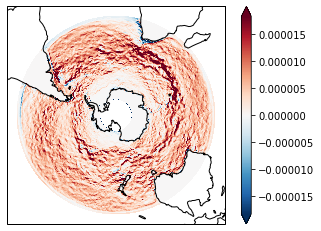

In [33]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
dsst_dy.plot(ax=ax, robust=True, transform=ccrs.PlateCarree())
ax.coastlines()

The meridional gradient is positive over the whole domain (temperature is increasing towards the equator), as might be expected. The stronges gradient is associated with the boundary between the retroflection of the warm [Agulhas current](https://en.wikipedia.org/wiki/Agulhas_Current) and the cold waters of the [Antarctic Circumpolar Current](https://en.wikipedia.org/wiki/Antarctic_Circumpolar_Current) in the Indian Ocean sector.